In [1]:
import tensorflow as tf

from tensorflow.keras.models import load_model

import sys
import os
import glob
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as k
from glob import glob
import numpy as np
from tqdm import tqdm
import shutil

In [2]:
!nvidia-smi

Thu Mar  4 05:22:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#1344
img_width, img_height = 224, 224
nb_classes = 196

seed = 727
batch_size= 64
epochs = 50

data_dir = "drive/MyDrive/data/stanford-car-dataset-by-classes-folder-224/car_data/"

size= 224

In [4]:
# base_model = efn.EfficientNetB5(include_top=False, #weights='imagenet', input_shape=(img_width, img_height, 3))
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(nb_classes, activation='softmax')(x)
# add your top layer block to your base model
model = Model(base_model.input, predictions)

87916544/87910968 [==============================] - 1s 0us/step


In [5]:
def norm(x) :
  x /= 255.-0.5
  return x

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function = norm,rotation_range=0, width_shift_range=5.0,\
                                   height_shift_range=5.0, brightness_range=(0.8,1.2), zoom_range=0.05,\
                                   fill_mode='nearest', horizontal_flip=True,\
                                   vertical_flip=False, validation_split=0.2)
val_datagen = ImageDataGenerator(preprocessing_function = norm)

train_generator = train_datagen.flow_from_directory(
    data_dir+'train',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(    
    data_dir+'train',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset = 'validation',

)

test_generator = val_datagen.flow_from_directory(    
    data_dir+'test',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(device_name)

/device:GPU:0


In [ ]:
# os.makedirs(data_dir + 'weights')
with tf.device('/device:GPU:0'):
  checkpoint = ModelCheckpoint(filepath=os.path.join(data_dir,'weights','car_inceptionV3.hdf5'), 
              monitor='val_accuracy', 
              mode='max', 
              save_best_only=True)

  early_stop = EarlyStopping(monitor='val_accuracy', verbose = 1, patience = 10)

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=1e-4),
                metrics=['accuracy'])

  history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=validation_generator.n // validation_generator.batch_size,
          callbacks=[early_stop,checkpoint]
          )

Epoch 1/50
103/103 [==============================] - 6297s 61s/step - loss: 5.1732 - accuracy: 0.0292 - val_loss: 4.1111 - val_accuracy: 0.1217
Epoch 2/50
103/103 [==============================] - 128s 1s/step - loss: 3.3266 - accuracy: 0.3537 - val_loss: 2.8788 - val_accuracy: 0.3177
Epoch 3/50
103/103 [==============================] - 125s 1s/step - loss: 1.8567 - accuracy: 0.6679 - val_loss: 2.0891 - val_accuracy: 0.5124
Epoch 4/50
103/103 [==============================] - 125s 1s/step - loss: 0.9915 - accuracy: 0.8279 - val_loss: 1.6402 - val_accuracy: 0.5977
Epoch 5/50
103/103 [==============================] - 126s 1s/step - loss: 0.5197 - accuracy: 0.9221 - val_loss: 1.4650 - val_accuracy: 0.6426
Epoch 6/50
103/103 [==============================] - 126s 1s/step - loss: 0.2961 - accuracy: 0.9623 - val_loss: 1.3179 - val_accuracy: 0.6693
Epoch 7/50
103/103 [==============================] - 126s 1s/step - loss: 0.1605 - accuracy: 0.9825 - val_loss: 1.2711 - val_accuracy: 0.67

In [8]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pylab as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [9]:
cs = list(validation_generator.class_indices.keys())
cs

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [10]:
def custom_model():
    base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(img_width, img_height, 3))

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    # add your top layer block to your base model
    return Model(base_model.input, predictions)

loaded_model = custom_model()

file_name = 'car_inceptionV3.hdf5'

loaded_model.load_weights(os.path.join(data_dir,'weights',file_name))

print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

Loaded model from disk


126/126 [==============================] - 2503s 20s/step - loss: 1.3294 - accuracy: 0.6722
accuracy : 71.82%
Confusion matrix, without normalization
[[37  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0 32  0]
 [ 0  0  0 ...  0  0 32]]


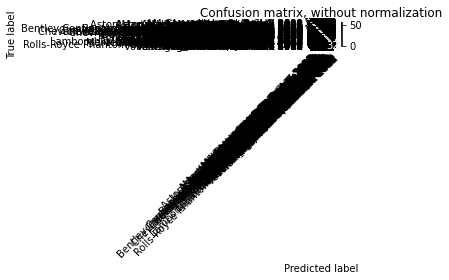

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# each image (7*7 images)
test_generator.reset()
score = loaded_model.evaluate(test_generator, steps = test_generator.n // batch_size+1)

print("%s : %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

test_generator.reset()
Y_pred = loaded_model.predict(test_generator, steps=test_generator.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

plot_confusion_matrix(test_generator.classes, y_pred,classes = np.array(cs))

plt.show()

In [ ]:
pred_ok_idx = np.where((y_pred==1))[0]
pred_ok_path = np.array(test_generator.filepaths)[pred_ok_idx]
len(pred_ok_path)

In [ ]:
leak_idx = np.where((validation_generator.classes==6) & (y_pred!=6))[0]
leak_path = np.array(validation_generator.filepaths)[leak_idx]

In [ ]:
from PIL import Image
plt.figure(figsize = (20,20))
for i,img in enumerate(leak_path) :
    plt.subplot(5,5,i+1)
    plt.imshow(Image.open(img), cmap='gray')
    plt.title((img.split('/')[-2], cs[y_pred[i]], np.max(Y_pred[leak_idx[i]])))
    plt.axis('off')
plt.show()

In [ ]:
loss_idx = np.where((test_generator.classes==1) & (y_pred==0))[0]
loss_path = np.array(test_generator.filepaths)[loss_idx]

In [ ]:
plt.figure(figsize = (20,20))
for i,img in enumerate(loss_path) :
    plt.subplot(5,5,i+1)
    plt.imshow(Image.open(img), cmap='gray')
    plt.axis('off')
plt.show()